# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

## Import des Librairies

In [24]:
#Classic imports
import numpy as np 
import pandas as pd 
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import os 
#from google.colab import files

# Import English using en_core_web_sm.load()
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

import html
import re
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
import wordcloud
from wordcloud import WordCloud,STOPWORDS
#import gensim
from nltk.stem import WordNetLemmatizer
import string 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!pip install -U pip setuptools wheel
!pip install -U spacy

In [2]:
!python -m spacy download fr_core_news_sm
import spacy
nlp = spacy.load("fr_core_news_sm")

2022-02-13 14:42:28.757762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 14:42:28.757828: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 20.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [119]:
#Loading Data
train = pd.read_csv("train.csv",  dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv("test.csv",dtype={'id': np.int16})
sub_sample = pd.read_csv("sample_submission.csv")

# Data Understanding and Visualization

In [120]:
test.shape

(3263, 4)

In [121]:
train.shape

(7613, 5)

In [122]:
# Real disaster tweet (1) or not (0)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [123]:
#Return boolean Series denoting duplicate rows.
train.duplicated().sum()

0

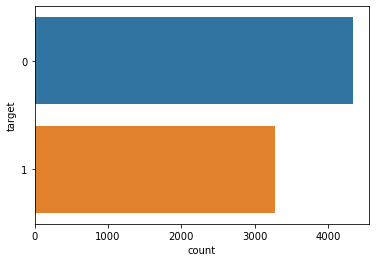

In [124]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train.target);

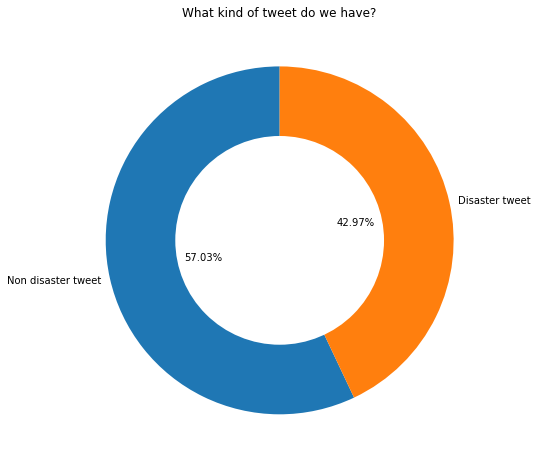

In [125]:
plt.figure(figsize=(16,8))
train.target.value_counts(dropna=False).plot(kind='pie',autopct='%1.2f%%',pctdistance = 0.45, labels= ["Non disaster tweet", "Disaster tweet"], labeldistance = 1.05, startangle = 90)
plt.title('What kind of tweet do we have?')
plt.ylabel("")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [126]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [127]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## Check number of unique keywords

In [128]:
print (train.keyword.nunique(), test.keyword.nunique())

221 221


## Most common words

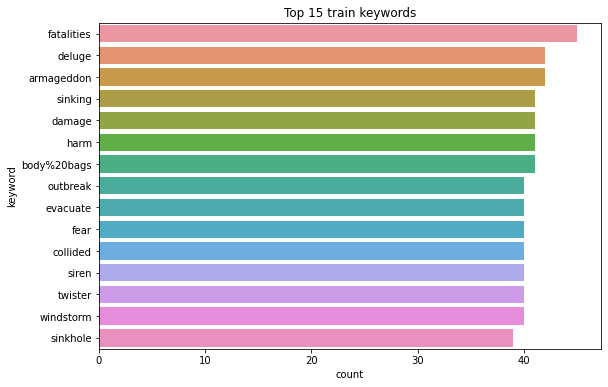

In [129]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 train keywords')
plt.show()

## Top 10 words in disaster and non-disaster tweets

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


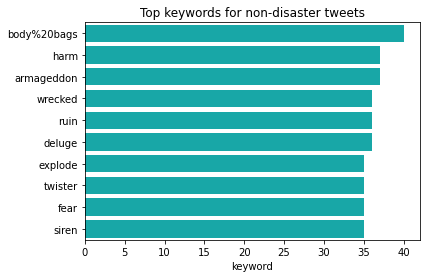

In [130]:
# Top 10 key words in non-disaster tweets
kw_nd = train[train.target==0].keyword.value_counts().head(10)
sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for non-disaster tweets')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


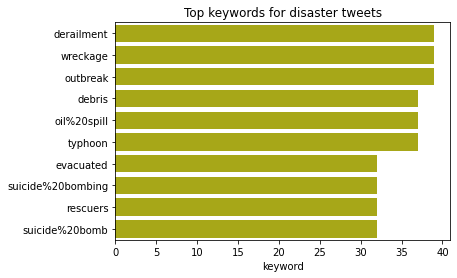

In [131]:
# Top 10 key words in disaster tweets
kw_d = train[train.target==1].keyword.value_counts().head(10)
sns.barplot(kw_d, kw_d.index, color='y')
plt.title('Top keywords for disaster tweets')
plt.show()

A part le mot "wreckage", on ne retrouve pas de mots communs entre les disatster et non-disaster tweets 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


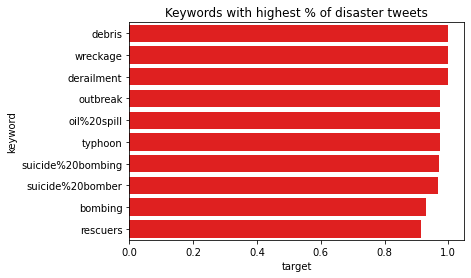

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


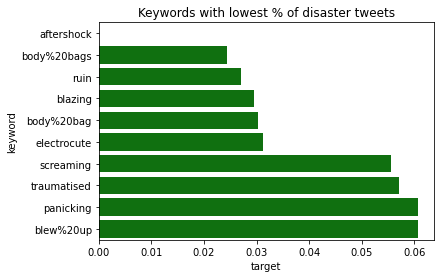

In [132]:
# Highest and lowest % of disater tweets by keywords
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

sns.barplot(top_d, top_d.index, color='red')
plt.title('Keywords with highest % of disaster tweets')
plt.show()
sns.barplot(top_nd, top_nd.index, color='green')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

In [133]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


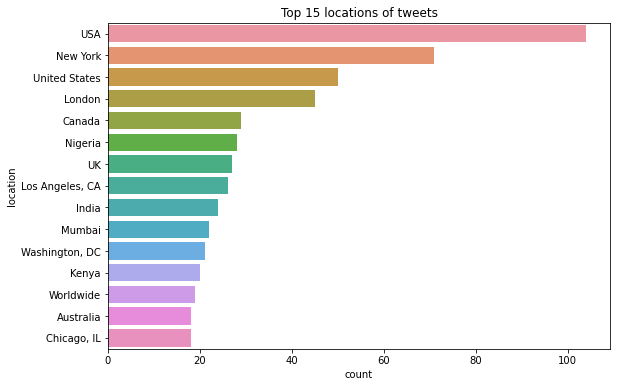

In [134]:
# Most common locations of tweets
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations of tweets')
plt.show()

As location is free text, the data is not clean, we can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

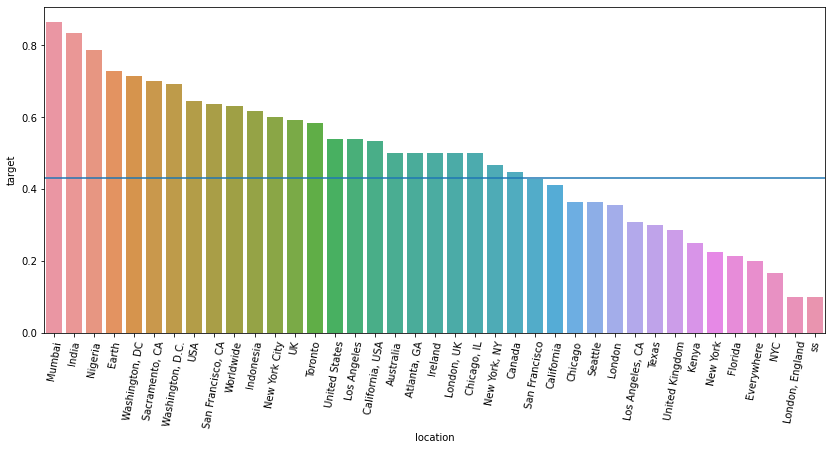

In [135]:
# Moyennes des disaster tweets groupées par tops locations (nbr de tweets >= 10)
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

# Data Cleaning

In [136]:
# used the code described here [Data cleaning](https://gist.github.com/bicachu/09cc71bb4b0e3711eaf1556b12fa7ad7) by John Bica

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

#This might worsen our results as it removes essential words
def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_punct(tweet):
    table=str.maketrans('','',string.punctuation)
    return tweet.translate(table)

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet   

def remove_emojis(tweet):
    tweet = re.sub("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+",'', tweet)
    return tweet

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = remove_emojis(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def stopword_removal(tweet):
  return ' '.join([word for word in tweet.split() if word not in STOP_WORDS])

def lemmatization(token):
  return WordNetLemmatizer().lemmatize(token, pos='v')

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    #tweet = remove_hashtags(tweet)
    tweet = remove_punct(tweet)
    tweet = remove_av(tweet)
    tweet = remove_emojis(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    tweet = stopword_removal(tweet)
    tweet =' '.join([lemmatization(token) for token in tweet.split() if len(token) > 2])
    return tweet

In [137]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [138]:
train["text_cleaned"] = train["text"].apply(basic_clean)
train.head()

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents ask shelter place notify officer eva...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation order cali...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfires pou...


In [139]:
test["text_cleaned"] = train["text"].apply(basic_clean)
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,deeds reason earthquake allah forgive
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",forest fire near ronge sask canada
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",residents ask shelter place notify officer eva...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,people receive wildfires evacuation order cali...
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,get send photo ruby alaska smoke wildfires pou...


In [140]:
# visulsation of a cleaned tweet (beforehand with a link)
test_str = train.loc[417, 'text']
test_str_cln = train.loc[417, 'text_cleaned']
print("Original text: " + test_str)
print("Cleaned text: " + test_str_cln)

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: arson suspect link fire catch northern california


In [141]:
# Fonctions for getting : hashtags, mentions and links
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    
    return df
    
train_cl = process_text(train)
test_cl = process_text(test)

In [142]:
train_cl.head()

,id,keyword,location,text,target,text_cleaned,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake allah forgive,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents ask shelter place notify officer eva...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation order cali...,wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfires pou...,Alaska wildfires,no,no


In [143]:
test_cl.head()

,id,keyword,location,text,text_cleaned,hashtags,mentions,links
0,0,NaN,NaN,Just happened a terrible car crash,deeds reason earthquake allah forgive,no,no,no
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",forest fire near ronge sask canada,earthquake,no,no
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",residents ask shelter place notify officer eva...,no,no,no
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,people receive wildfires evacuation order cali...,Spokane wildfires,no,no
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,get send photo ruby alaska smoke wildfires pou...,no,no,no


## WordClouds

In [144]:
words = train["text_cleaned"].values

(-0.5, 399.5, 199.5, -0.5)

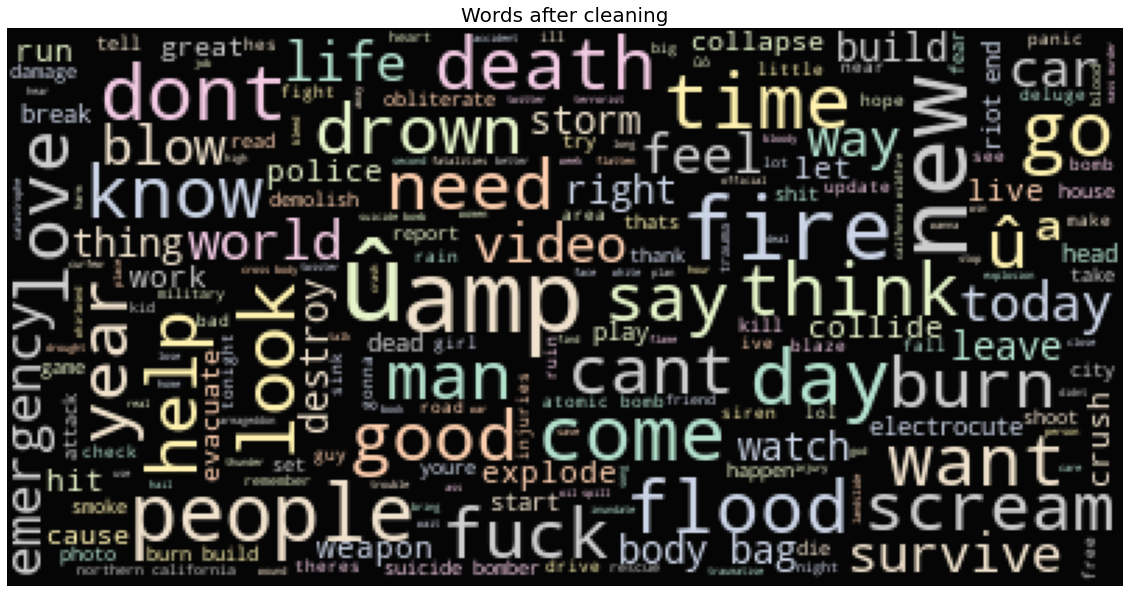

In [145]:
plt.figure(figsize=(20,18))
wc = WordCloud( background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(words))
plt.title("Words after cleaning", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

## Tf-idf for text

In [52]:
# Tfidf transformer 
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words = 'english', smooth_idf = True)
X = vectorizer.fit_transform(train['text_cleaned'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
# Creating a DataFrame with all the words and tf-idf score 
tfid_df = pd.DataFrame(dense, 
                        columns=[x for x in vectorizer.get_feature_names_out()])

tfid_df

,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aampb,aampw,aan,aannnnd,aar,aashiqui,...,ûò,ûòthe,ûòåêcnbc,ûó,ûóbbc,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Counting words
word_count = list()
words = tfid_df.columns.to_list()
word_count = [(tfid_df[z] != 0.0).sum() for z in tfid_df.columns]

In [55]:
data_word_count = pd.DataFrame(zip(words,word_count), columns = ['word', 'count'])
data_word_count[data_word_count['count']>1].sort_values(by = 'count', ascending=False)[:10]

,word,count
6268,like,373
368,amp,270
1236,bomb,226
7374,new,218
8125,people,193
7386,news,187
3095,dont,185
1473,burn,172
11020,time,171
5933,kill,163


In [56]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_cleaned',
       'hashtags', 'mentions', 'links'],
      dtype='object')

### Tokznization

In [63]:
# Checking the maximum length of a token to assess the padding needed after (Let's see what is our max length in cleaned words to assess the padding needed on the overall dataset ### Explain padding)
train['token_length'] = train.text_cleaned.apply(lambda x: len(x))
number_of_words = train['token_length'].sum()

#Instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = number_of_words)

#Fit it on the text before encoding it in sequences
tokenizer.fit_on_texts(train['text_cleaned'])

#Convert it to sequences
train['encoded_text'] = tokenizer.texts_to_sequences(train['text_cleaned'])

#We'll drop as well the useless columns we don't need anymore
train = train[['text','target','text_cleaned','encoded_text','token_length']]

In [66]:
train.head()

,text,target,text_cleaned,encoded_text,token_length
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake allah forgive,"[3425, 474, 173, 1214, 1635]",37
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,"[107, 2, 147, 5103, 5104, 1064]",34
2,All residents asked to 'shelter in place' are ...,1,residents ask shelter place notify officer eva...,"[1325, 437, 1636, 319, 5105, 282, 174, 1636, 3...",80
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation order cali...,"[7, 2205, 1065, 174, 266, 32]",52
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfires pou...,"[6, 163, 228, 5106, 1870, 152, 1065, 2206, 98]",54


SVM

In [156]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [112]:
tfidf = TfidfVectorizer()
classifier = LinearSVC()

In [220]:
x = train['text_cleaned']
y = train['target']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [222]:
tfidf.fit(x)

TfidfVectorizer()

In [223]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [224]:
classifier.fit(X_train_tf,y_train )

LinearSVC()

In [225]:
y_pred = classifier.predict(X_test_tf)

In [226]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       874
           1       0.77      0.70      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [227]:
Test = tfidf.transform(test['text_cleaned'])

In [228]:
y_pred_test= classifier.predict(Test)

In [229]:
predict_file = pd.DataFrame({'id':test['id'],'target':y_pred_test.round().astype(int)})
# predict_file.to_csv('submission.csv',index=False)

RNN

In [230]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [231]:
max_words = 4000
max_len = 40
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [232]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model_lstm = Model(inputs=inputs,outputs=layer)
    return model_lstm

In [233]:
model_lstm = RNN()
model_lstm.summary()
model_lstm.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 40)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 40, 50)            200000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [234]:
history_lstm = model_lstm.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Epoch 1/10
39/39 [==============================] - 5s 74ms/step - loss: 0.6209 - accuracy: 0.6615 - val_loss: 0.7044 - val_accuracy: 0.5345
Epoch 2/10
39/39 [==============================] - 2s 59ms/step - loss: 0.4173 - accuracy: 0.8159 - val_loss: 0.5049 - val_accuracy: 0.7586
Epoch 3/10
39/39 [==============================] - 2s 59ms/step - loss: 0.3336 - accuracy: 0.8660 - val_loss: 0.5275 - val_accuracy: 0.7964
Epoch 4/10
39/39 [==============================] - 2s 60ms/step - loss: 0.2871 - accuracy: 0.8879 - val_loss: 0.5317 - val_accuracy: 0.7964
Epoch 5/10
39/39 [==============================] - 2s 57ms/step - loss: 0.2551 - accuracy: 0.9025 - val_loss: 0.5939 - val_accuracy: 0.7709
Epoch 6/10
39/39 [==============================] - 2s 59ms/step - loss: 0.2295 - accuracy: 0.9128 - val_loss: 0.5976 - val_accuracy: 0.7833
Epoch 7/10
39/39 [==============================] - 2s 61ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.7356 - val_accuracy: 0.7791
Epoch 8/10
39

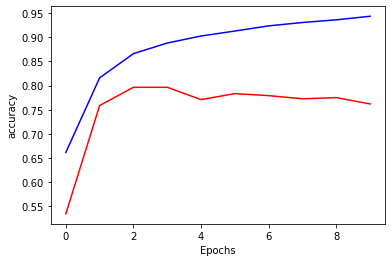

In [235]:
#Visualization of the training process on the accuracy
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [219]:
history_lstm = model_lstm.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
39/39 [==============================] - 5s 73ms/step - loss: 0.6382 - accuracy: 0.6404 - val_loss: 0.5427 - val_accuracy: 0.7504
Epoch 2/10
39/39 [==============================] - 2s 58ms/step - loss: 0.4317 - accuracy: 0.8159 - val_loss: 0.5187 - val_accuracy: 0.7890


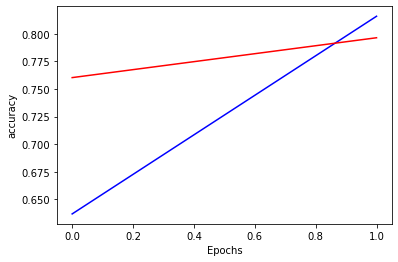

In [204]:
#Visualization of the training process on the accuracy
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [170]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [171]:
accr = model_lstm.evaluate(test_sequences_matrix,y_test)

48/48 [==============================] - 0s 8ms/step - loss: 0.4705 - accuracy: 0.7833


In [173]:
test_X = list(test["text_cleaned"])

# Convert text to sequences
sequences = tok.texts_to_sequences(test_X)

# Pad sequences
sequences_matrix = sequence.pad_sequences(sequences,
                             maxlen=max_len,
                             dtype='int32',
                             value=0)

# Predict sequences
predicted = model_lstm.predict(sequences_matrix)

binary_predicted = np.array(predicted) >= 0.5
targets = binary_predicted.astype(int).reshape((len(binary_predicted)))
# my_submission = pd.DataFrame({'id': disaster_tweets_test.id, 'target': targets})
# my_submission.to_csv('submission.csv', index=False)

print("Submission file created!")

Submission file created!


### Error Analysis For LSTM

In [174]:
predicted = pd.DataFrame(predicted)
predicted.columns = ['predicted']
predicted.to_csv('train_preds.csv', index=False)

In [175]:
df_train_preproc = train
df_train_preproc.to_csv('df_train_preprocessed.csv')

In [176]:
y_train[0:10]

4996    1
3263    0
4907    1
2855    1
4716    0
7538    1
3172    1
3932    1
5833    1
7173    0
Name: target, dtype: int8

In [178]:
df_train_erroe = pd.read_csv("train.csv")
df_train_preproc = pd.read_csv("df_train_preprocessed.csv")
train_preds = pd.read_csv('train_preds.csv')

In [179]:
train_preds[0:10].T

,0,1,2,3,4,5,6,7,8,9
predicted,0.68811,0.920583,0.933995,0.949814,0.22991,0.980903,0.95239,0.793243,0.864822,0.843319


### Add our predictions along the original data

In [182]:
combined = pd.concat([df_train_erroe, train_preds], axis=1, sort=False)
combined.head()

,id,keyword,location,text,target,predicted
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.688110
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.920583
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.933995
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.949814
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.229910
